# Single cell kernel Current Source Density (sKCSD)
#### In this tutorial we will cover three topics: 
- Data format for sKCSD estimation
- sKCSD method
- Source visualization. 

In [38]:
from kcsd import sKCSDcell, sKCSD, sample_data_path
from kcsd import utility_functions as utils
from kcsd.sKCSD_utils import LoadData
import numpy as np
import matplotlib.pyplot as plt
import os

In [39]:
data_fname = os.path.join(sample_data_path, "gang_7x7_200")

In [40]:
data = LoadData(data_fname)

Load /home/heba/Neuroinformatics/Internship/neuro/lib/python3.10/site-packages/kcsd/data/gang_7x7_200/morphology/gang_7x7_200_rows_4_cols_5_xmin_-20_xmax_20_ymin_-20_ymax_20_orientation_3.swc
Load /home/heba/Neuroinformatics/Internship/neuro/lib/python3.10/site-packages/kcsd/data/gang_7x7_200/electrode_positions/elcoord_x_y_z
Load /home/heba/Neuroinformatics/Internship/neuro/lib/python3.10/site-packages/kcsd/data/gang_7x7_200/LFP/MyLFP


<span style="color:blue">**Data Organization:**</span>

The data is structured into three subdirectories:

- **morphology:** Contains a single file in the swc morphology format.
- **electrode_positions:** Contains a single file with electrode positions. The electrode positions can be provided as a text file with either one column (representing x, y, and z positions for each electrode) or three columns (representing x, y, and z electrode positions).
- **LFP:** Contains a single text file with LFP (Local Field Potential) data. The file should have dimensions n_electrodes x n_time_samples.

**LoadData Class:**

The `LoadData` class is designed to handle the loading of this structured data. It provides the following functionalities:

- Supports only the swc morphology format.
- Interprets electrode positions from a text file with either one or three columns.
- Expects LFP data in a text file with dimensions n_electrodes x n_time_samples.

**Usage Example:**

To load data into the `LoadData` object, use the `assign` function. Here's an example:

```python
data1 = LoadData()
data1.assign('morphology', path_to_morphology_file)
data1.assign('electrode_positions', path_to_electrode_positions_file)
data1.assign('LFP', path_to_LFP_file)


<span style="color:blue">**Data Generation and Unit Standardization:**</span>

The dataset employed in this tutorial was created through the execution of `figures/skcsd_paper/run_LFPy.py`, a script designed for running example simulations utilizing the LFPy library. 
Notably, LFPy adopts 
- millivolts (mV) for voltage
- milliseconds (ms) for time
- micrometers (um) for distance (or position).

To align with the requirements of the sKCSD (spatial KCSD) and KCSD (kernel current source density) methods, which mandate data to be in SI units, a crucial step involves <b>scaling the data.</b> This process ensures consistency and coherence with the International System of Units (SI).

The conversion factors are as follows:
- Voltage: 1 mV in LFPy corresponds to 1e-3 V in SI units.
- Time: 1 ms in LFPy corresponds to 1e-3 s in SI units.
- Distance: 1 um in LFPy corresponds to 1e-6 m in SI units.

This meticulous unit standardization is imperative for accurate and meaningful sKCSD estimation, allowing for seamless integration into the SI unit framework.


In [41]:
data.LFP /= 1e3
data.morphology[:, 2:6] /= 1e6
data.ele_pos /= 1e6

### Let us visualise the current density.

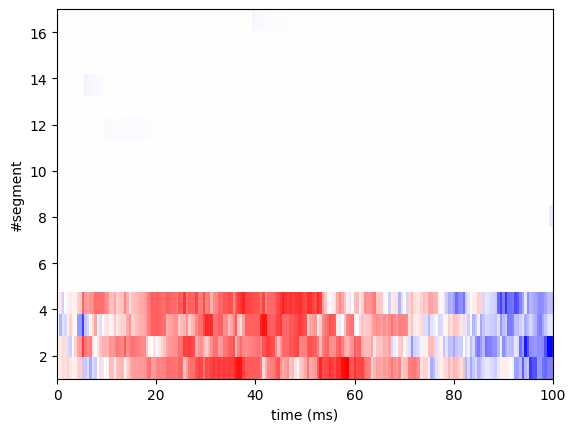

In [42]:
#Other parameters
time = np.loadtxt(os.path.join(data_fname, 'tvec.txt'))
seglen = np.loadtxt(os.path.join(data_fname, 'seglength'))
ground_truth = np.loadtxt(os.path.join(data_fname, 'membcurr'))/seglen[:, None]*1e-3
vmin, vmax =  ground_truth.min(), ground_truth.max()
if abs(vmin) > abs(vmax):
    vmax = abs(vmin)
else:
    vmin = -vmax
fig, ax = plt.subplots(1, 1)
ax.set_aspect('equal')
ax.set_xlabel('time (ms)')
ax.set_ylabel('#segment')
ax.imshow(ground_truth, origin="lower", aspect="auto", interpolation="none", cmap="bwr", vmin=vmin, vmax=vmax, extent=[time[0], time[-1], 1, len(seglen)])


### Corresponding voltage in the soma:

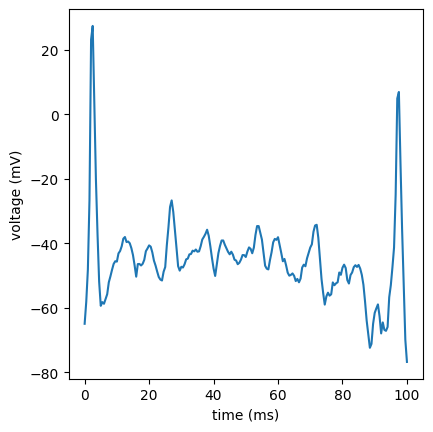

In [43]:
somav = np.loadtxt(os.path.join(data_fname, 'somav.txt'))
fig, ax = plt.subplots(1, 1)
ax.set_aspect('equal')
ax.set_xlabel('time (ms)')
ax.set_ylabel('voltage (mV)')
ax.plot(time, somav)

### To calculate sKCSD 
you must specify 
- The width of the source (R) 
- Noise level (lambd). 

For neuron morphologies R is going to be of the order of microns. 
We specified lambd = 10000, which amounts to roughly 10% noise.

In [44]:
n_src = 25
R = 8e-6
lambd = 0.0001
ker = sKCSD(data.ele_pos,
            data.LFP,
            data.morphology,
            n_src_init=n_src,
            src_type='gauss',
            lambd=lambd,
            R_init=R,
            exact=True,
            sigma=0.3)

After the sKCSD calculation, you can retrieve the potential or current source density using `skcsd.values(estimate)`. 
- For potential estimation, set `estimate="POT"`
- for current density estimation, set `estimate='CSD'`. 

By default, `skcsd.values()` provides the current source density (CSD).

In [54]:
skcsd = ker.values(transformation="segments")

### sKCSD Output and Transformation:

Both current density and potential are computed in the 1D space of the morphology loop. The `sKCSD.values(estimate, transformation)` function is employed to calculate either Current Source Density (CSD) when `estimate="CSD"` or potential when `estimate="POT"`. This function allows for transformations to segments and a 3D morphology. To perform no transformation, specify `transformation=None`.

By default (`sKCSD.values()`), potential and current density are transformed to a 3D cube spanning from (`xmin, ymin, zmin`) to (`xmax, ymax, zmax`). This enables efficient storage of cell morphology, morphology loop, source positions, and facilitates seamless transformations between morphology (segments), morphology loop, and the 3D cube.

To manage these transformations and store essential information, sKCSD utilizes a dedicated object called `sKCSDcell`. The default behavior of sKCSD involves extracting minimum and maximum neuron coordinates from the swc file.

Text(0.5, 1.0, 'estimated current density')

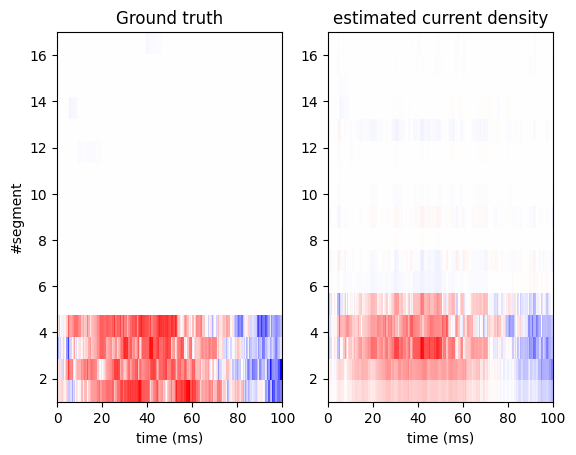

In [55]:
fig, ax = plt.subplots(1, 2)
ax[1].set_aspect('equal')
ax[1].set_xlabel('time (ms)')
ax[1].imshow(skcsd, origin="lower", aspect="auto",
             interpolation="none", cmap="bwr",
             vmin=vmin, vmax=vmax,
             extent=[time[0], time[-1], 1, len(seglen)])
ax[0].set_aspect('equal')
ax[0].set_xlabel('time (ms)')
ax[0].set_ylabel('#segment')
ax[0].imshow(ground_truth, origin="lower", aspect="auto",
             interpolation="none", cmap="bwr",
             vmin=vmin, vmax=vmax,
             extent=[time[0], time[-1], 1, len(seglen)])
ax[0].set_title('Ground truth')
ax[1].set_title('estimated current density')


### To calculate CSD in the 3D cube:

In [56]:
skcsd_3D =  ker.values(transformation="3D")

### To visualize morphology you can use the sKCSD cell object:

In [57]:
morpho_z, extent = ker.cell.draw_cell2D(axis=2, segments=False)
extent = [extent[-2]*1e6, extent[-1]*1e6, extent[0]*1e6, extent[1]*1e6]

### Visualization with draw_cell2D:

The `draw_cell2D(axis)` function in sKCSD facilitates a 2D visualization of the 3D morphology. This visualization includes the representation of minimum and maximum coordinates of the 2D view, known as the extent, along a specified axis. The default axis is the Z axis, denoted as 2.

Key Parameters:
- `axis`: Specifies the axis for the 2D view (0 for x, 1 for y, and 2 for z).
  
By default, the Z axis is chosen. The extent of the 2D view varies based on the chosen axis:
- For projections along the X-axis, the extent is [ymin, ymax, zmin, zmax].
- For projections along the Y-axis, the extent is [xmin, xmax, zmin, zmax].
- For projections along the Z-axis, the extent is [xmin, xmax, ymin, ymax].

Additionally:
- If `segments=True`, the cell is drawn using segment coordinates.
- If `segments=False`, the cell is drawn using loop coordinates.

Note: When the number of sources (`n_src`) is low, the morphologies might differ between segment and loop coordinates.


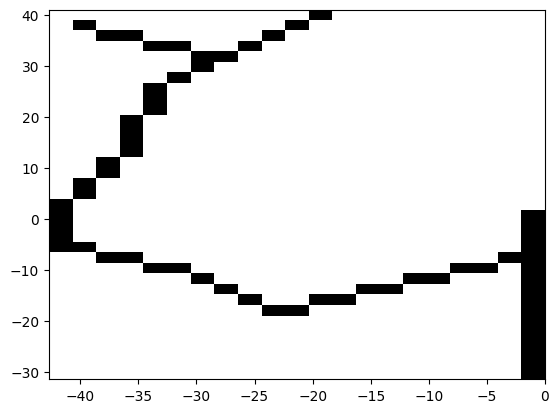

In [58]:
fig, ax = plt.subplots(1, 1)
ax.imshow(morpho_z, origin="lower", aspect="auto", interpolation="none", extent=extent)

### Or create a new sKCSDcell object using morphology data and electrode positions:

(35, 21) [-42.7, 0.0, -31.46, 40.95]


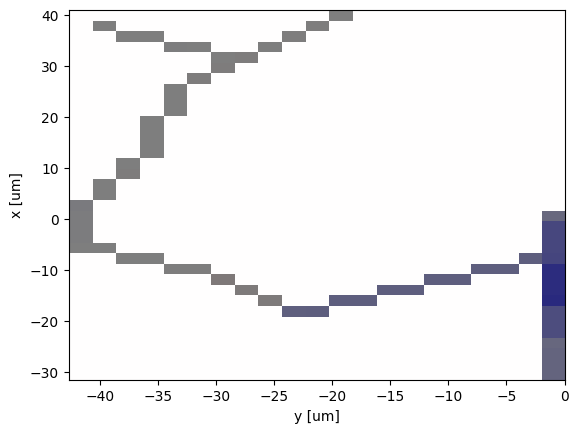

In [59]:
n_src = 25
cell_itself = sKCSDcell(data.morphology, data.ele_pos, n_src)
morpho, extent = cell_itself.draw_cell2D(axis=2, segments=False)
extent = [extent[-2], extent[-1], extent[0], extent[1]]
extent = [x*1e6 for x in extent]
fig, ax = plt.subplots(1, 1)
ax.imshow(morpho, origin="lower", aspect="auto", interpolation="none", extent=extent)
ax.set_ylabel('x [um]')
ax.set_xlabel('y [um]')
idx = np.where(time == 40)[0][0]
csd = skcsd_3D[:, :, :, idx].sum(axis=(2))
print(csd.shape, extent)
ax.imshow(csd, origin="lower", aspect="auto", interpolation="none", extent=extent, vmin=vmin, vmax=vmax, alpha=.5, cmap=plt.cm.bwr_r)

### Customizing sKCSDcell Object:

When an sKCSDcell object is created by sKCSD, it automatically inherits the minimum and maximum 3D coordinates from the morphology. However, when a separate sKCSDcell object is created, users have the flexibility to define custom coordinates:

- `xmin`, `ymin`, `zmin`: Custom minimum coordinates in the x, y, and z directions.
- `xmax`, `ymax`, `zmax`: Custom maximum coordinates in the x, y, and z directions.

These custom coordinates can be particularly useful for tailored visualizations, such as plotting CSD and electrode positions.

**Tolerance Parameter:**
Another parameter to consider is `tolerance`, which determines the minimum width of the voxel in any direction. The default value is set to 2 micrometers (um).

By adjusting these parameters, users can fine-tune the sKCSDcell object to match their specific requirements for visualization and analysis.


In [60]:
tolerance = 3e-6
xmin = data.ele_pos[:, 0].min() - 50e-6
xmax = data.ele_pos[:, 0].max() + 50e-6
ymin = data.ele_pos[:, 1].min() - 40e-6
ymax = data.ele_pos[:, 1].max() + 40e-6
zmin = data.ele_pos[:, 2].min() - 50e-6
zmax = data.ele_pos[:, 2].max() + 50e-6
cell_itself = sKCSDcell(data.morphology, data.ele_pos, n_src,
                        xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax,
                        zmin=zmin, zmax=zmax, tolerance=tolerance)

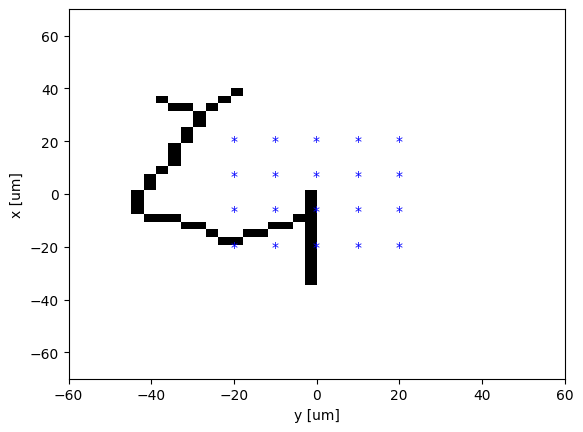

In [61]:
morpho_z, extent = cell_itself.draw_cell2D(axis=2, segments=False)
extent = [extent[-2], extent[-1], extent[0], extent[1]]
extent = [x*1e6 for x in extent]
fig, ax = plt.subplots(1, 1)
ax.imshow(morpho_z, origin="lower", aspect="auto", interpolation="none", extent=extent)
ax.set_ylabel('x [um]')
ax.set_xlabel('y [um]')
for i in range(len(data.ele_pos)):
    pos_x, pos_y = data.ele_pos[i, 1]*1e6, data.ele_pos[i, 0]*1e6
    ax.text(pos_x, pos_y, '*', ha="center", va="center", color="b")

### Visualizing CSD on Morphology at t = 40 ms

- To visualize the Current Source Density (CSD) on the neuron morphology at a specific time point (t = 40 ms), we employ sKCSDcell objects.
- These objects enable us to resize both the CSD and the potential, providing a clearer visualization within an extended space defined by (xmin, ymin, zmin) and (xmax, ymax, zmax).
- The recommended procedure involves using CSD in the morphology loop space (`ker.values(transformation=None)`) and then transforming these objects using the `transform_to_3D` method of sKCSDcell.


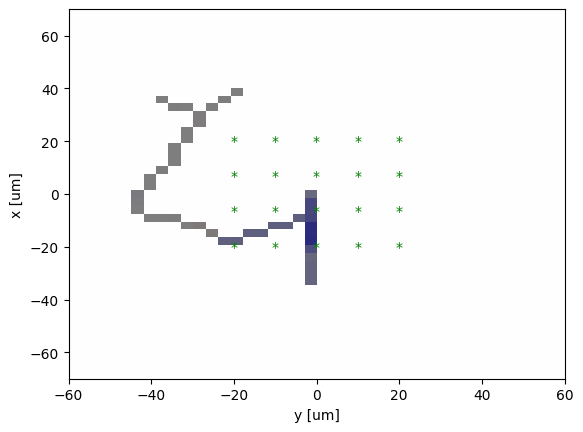

In [62]:
fig, ax = plt.subplots(1, 1)
ax.imshow(morpho_z, origin="lower", aspect="auto", interpolation="none", extent=extent)
ax.set_ylabel('x [um]')
ax.set_xlabel('y [um]')
skcsd = ker.values(transformation=None)
skcsd_3D = cell_itself.transform_to_3D(skcsd, what="loop")
idx = np.where(time == 40)[0][0]
csd = skcsd_3D[:, :, :, idx].sum(axis=(2))
ax.imshow(csd, origin="lower", aspect="auto", interpolation="none", extent=extent, vmin=vmin, vmax=vmax, alpha=.5, cmap=plt.cm.bwr_r)
ax.set_ylabel('x [um]')
ax.set_xlabel('y [um]')
for i in range(len(data.ele_pos)):
    pos_x, pos_y = data.ele_pos[i, 1]*1e6, data.ele_pos[i, 0]*1e6
    ax.text(pos_x, pos_y, '*', ha="center", va="center", color="g")